# OO FF NN

Build feed-forward NN to predict daily bike rental ridership.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


## Data Pre-Processing and EDA

Let's explore our data! Look at the features and target variables. Check for **categorical variables** and **continuous ones**.

In [2]:
dpath = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(dpath)

Check the number of columns we have.

In [3]:
len(rides.columns)

17

In [4]:
rides.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

### Categorical to Dummy Variables
We look at our categorical variables such as season, weather, month. To include these in the model, we'll need to make binary dummy variables. 

This is simple to do with Pandas, thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']

data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
print (data.columns)

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'casual', 'registered',
       'cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4',
       'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12',
       'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20',
       'hr_21', 'hr_22', 'hr_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')


Let's look at the number of columns in our dataset: 

`number of features` + `number of target columns`

In [7]:
len(data.columns)

59

### Scaling target variables
Now, we standardize the continuous variables (`quant_features`). That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.0.

In [8]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store scalings in a dictionary for later conversion
scaled_features = {}

for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [9]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


### Splitting the data into training, testing, and validation sets
We'll save the last 20 days of the data as test set after network training.

In [10]:
# Save the last 20 days 
test_data = data[-20*24:]

# What's left for validation and training
data = data[:-20*24] 

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']

# Test set
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# To split later as Training and Validation sets
features, targets = data.drop(target_fields, axis=1), data[target_fields]


How does our test data look?

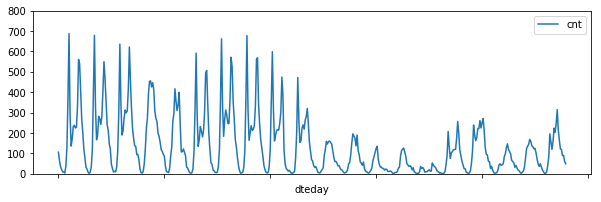

In [11]:
rides[-24*20:].plot(x='dteday', y='cnt', figsize=(10,3), ylim=(0,800));

As mentioned above, we split the remaining data into training and validation sets. The validation set can be thought of as "test" set while we are training the model. This is used to _also_ avoid overfitting.

In [12]:
# use last 60 days as validation set, the rest as training
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [13]:
train_features.head()

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [14]:
train_targets.head()

,cnt,casual,registered
0,-0.956312,-0.662736,-0.930162
1,-0.823998,-0.561326,-0.804632
2,-0.868103,-0.622172,-0.837666
3,-0.972851,-0.662736,-0.949983
4,-1.039008,-0.723582,-1.009445


For this exercise, we are only concerned in predicting the `cnt` variable. You may opt to drop `casual` and `registered` columns.